In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
import cartopy.feature as cfeature
from matplotlib import cm
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc
from matplotlib.colors import Normalize
from metpy.units import units
from scipy.ndimage import gaussian_filter

## MSLP

In [16]:
#%%capture

VALID_TIME = '2023-06-18T0600'

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -97
RIGHT_LON = -70

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20200722/hrrr_sfc.t12z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20210907/rap_15z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20230610/gfs_0p25_12z'

base_url = gfs

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values
    
mslp = ds.msletmsl.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME).squeeze().metpy.unit_array
uwnd = ds.ugrd10m.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME).squeeze().metpy.unit_array * units('m/s')
vwnd = ds.vgrd10m.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME).squeeze().metpy.unit_array * units('m/s')
cref = ds.refcclm.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME).squeeze().metpy.unit_array


def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

LOCAL_TIME = convert_datetime_from_nomads_to_local(VALID_TIME)
#time = ds.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME).squeeze()
#print(convert_datetime_from_nomads_to_local(time.time.values))

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.11/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


TypeError: strptime() argument 1 must be str, not numpy.datetime64

In [14]:
time.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:         (lev: 41, lat: 69, lon: 109)
Coordinates:
    time            datetime64[ns] 2023-06-18T06:00:00
  * lev             (lev) float64 1e+03 975.0 950.0 925.0 ... 0.04 0.02 0.01
  * lat             (lat) float64 23.0 23.25 23.5 23.75 ... 39.5 39.75 40.0
  * lon             (lon) float64 263.0 263.2 263.5 263.8 ... 289.5 289.8 290.0
Data variables: (12/215)
    absvprs         (lev, lat, lon) float32 ...
    no4lftxsfc      (lat, lon) float32 ...
    acpcpsfc        (lat, lon) float32 ...
    albdosfc        (lat, lon) float32 ...
    apcpsfc         (lat, lon) float32 ...
    capesfc         (lat, lon) float32 ...
    ...              ...
    vwshneg2pv      (lat, lon) float32 ...
    vwshtrop        (lat, lon) float32 ...
    watrsfc         (lat, lon) float32 ...
    weasdsfc        (lat, lon) float32 ...
    wiltsfc         (lat, lon) float32 ...
    var00212m       (lat, lon) float32 ...
Attributes:
    title:        

## Setup Basemap and Plot Data

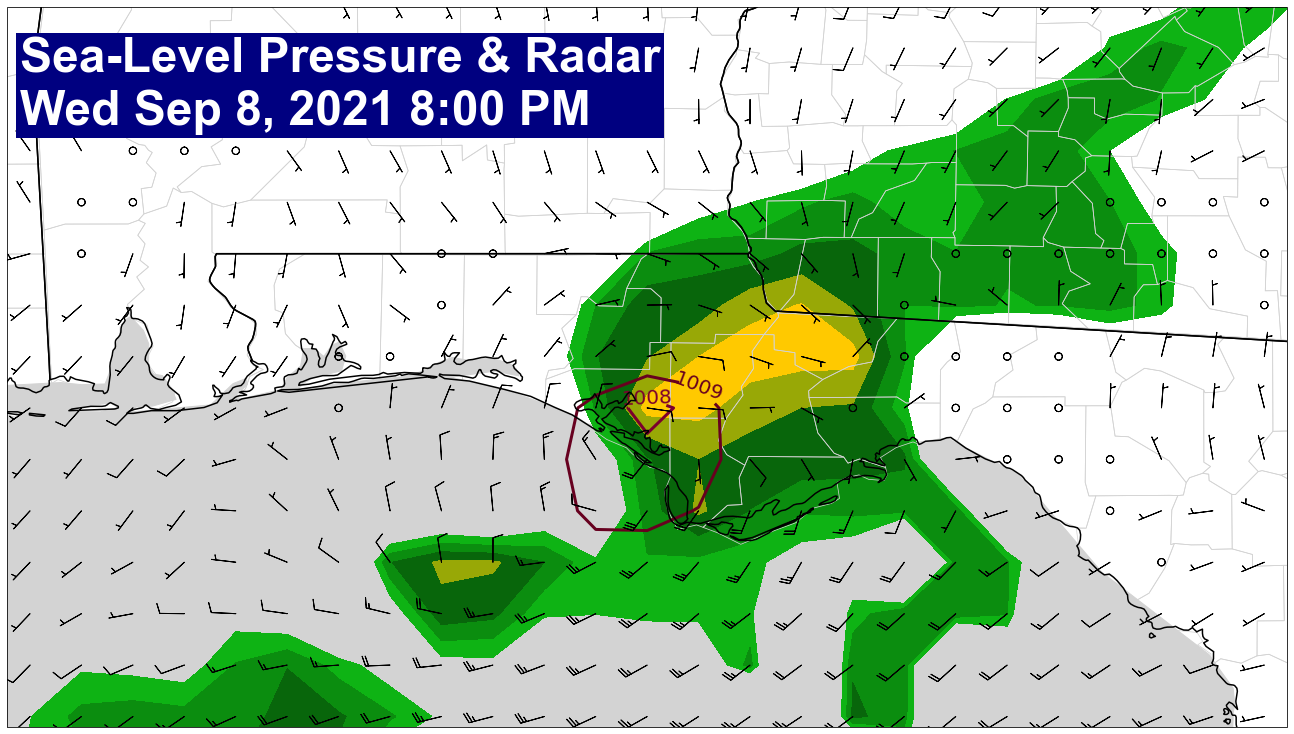

In [4]:
from Map import Map

new_map = Map('florida_panhandle')
new_map.add_counties()
new_map.add_title(f'Sea-Level Pressure & Radar\n{LOCAL_TIME}')

fig, ax = new_map.make_map()


# MEAN SEA-LEVEL PRESSURE
mslp_contour_values = np.arange(990, 1010, 1)
mslp_fill = ax.contour(lons, lats, mslp / 100, mslp_contour_values,
                        linewidths=3, linestyles='solid', zorder=2, extend='both',
                        cmap=cm.PuRd, transform=ccrs.PlateCarree())

ax.clabel(mslp_fill, inline=1, fontsize=20, fmt='%1.0f')


# COMPOSITE REFLECTIVITY
reflectivity_values = np.arange(20, 80, 5)
norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)
contour_fill = ax.contourf(lons, lats, cref, reflectivity_values,
                           cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())

# WIND BARBS
wind_slice = (slice(None, None, 1), slice(None, None, 1))

barbs = ax.barbs(lons[wind_slice[0]], lats[wind_slice[1]],
          uwnd[wind_slice].to('kt'), vwnd[wind_slice].to('kt'),
          color='black', zorder=2, transform=ccrs.PlateCarree())

# Save figure
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
fig.savefig(f'{graphics_dir}/mslp_{VALID_TIME}.png', dpi=72)